<a href="https://colab.research.google.com/github/MnCSSJ4x/Clustering-Project/blob/main/K_Means_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Summer Project : Clustering</h1>
<h3>Guide : Prof. Amit Chattopadhyay</h3>
<h5>Submitted By : Monjoy Narayan Choudhury and Karanjit Saha</h5>

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

<h1> Self Implementation of K-Means </h1> 

<h3> The part below has to be optimised </h3> 

In [ ]:
def eucledian_distance(x1,x2) :
  #need to change this with LNorm 
  return np.sqrt(np.sum((x1-x2)**2)) #vector based

def minkowski_distance(x1,x2,p):
  from scipy.spatial import distance
  return distance.minkowski(x1,x2,p)

In [ ]:
class Kmeans:
  #K = number of clusters
  #iter = number of iterations
  def __init__(self,K,iter,p):
    self.K=K
    self.iter=iter
    self.p=p
    #Initialising empty K clusters -> storing indicies
    self.clusters = [[] for _ in range(self.K)] 
    #storing centroids 
    self.centroids=[]

  def plus_plus(self,ds:np.array, k, random_state=1000):
    """
    Create cluster centroids using the k-means++ algorithm.
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    Inspiration from here: https://stackoverflow.com/questions/5466323/how-could-one-implement-the-k-means-algorithm
    """

    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

  '''def random(self,ds, k, random_state=42):
    """
    Create random cluster centroids.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    np.random.seed(random_state)
    centroids = []
    m = np.shape(ds)[0]

    for _ in range(k):
        r = np.random.randint(0, m-1)
        centroids.append(ds[r])

    return np.array(centroids)'''

  def naive_sharding(self,ds, k):
    """
    Create cluster centroids using deterministic naive sharding algorithm.
    
    Parameters
    ----------
    ds : numpy array
        The dataset to be used for centroid initialization.
    k : int
        The desired number of clusters for which centroids are required.
    Returns
    -------
    centroids : numpy array
        Collection of k centroids as a numpy array.
    """

    def _get_mean(sums, step):
        """Vectorizable ufunc for getting means of summed shard columns."""
        return sums/step

    n = np.shape(ds)[1]
    m = np.shape(ds)[0]
    centroids = np.zeros((k, n))

    composite = np.mat(np.sum(ds, axis=1))
    ds = np.append(composite.T, ds, axis=1)
    ds.sort(axis=0)

    step = math.floor(m/k)
    vfunc = np.vectorize(_get_mean)

    for j in range(k):
        if j == k-1:
            centroids[j:] = vfunc(np.sum(ds[j*step:,1:], axis=0), step)
        else:
            centroids[j:] = vfunc(np.sum(ds[j*step:(j+1)*step,1:], axis=0), step)

    return centroids
  
  def predict(self,X,choice=0): #no fit required for unsupervised learning models
    self.X=X
    self.n_samples,self.n_features = X.shape #numpy N-d array
    
    #initialise centroids
    if choice ==0:
      random_sample_idx = np.random.choice(self.n_samples,self.K,replace=False)
      self.centroids = [self.X[idx] for idx in random_sample_idx]
    elif choice == 1:
      self.centroids=self.plus_plus(X,self.K)
    elif choice == 2:
      self.centroids=self.naive_sharding(X,self.K)
    

    #optimise 
    for _ in range(self.iter):
      #update clusters
      self.clusters=self._create_clusters(self.centroids)

      #update centroids 
      centroids_old = self.centroids #for convergence test 
      self.centroids = self._get_centroids(self.clusters)
       #get cetnroids assign mean value of cluster to the centroid
      #check for convergence
      if self._isConverged(centroids_old,self.centroids):
        break

      #break 
    #classify the samples based on index of cluster
    return self.getClusterLabels(self.clusters)
    #return cluster labels 
  def _create_clusters(self,centroids):
    clusters = [[] for _ in range(self.K)]
    for idx,sample in enumerate(self.X):
      #find the closest centroid to classify, then put it in the specific cluster
      #here cluster is an list of list 
      centroid_idx = self._closest_centroid(sample,centroids)
      clusters[centroid_idx].append(idx)
    return clusters
  def _closest_centroid(self,sample,centroids):
    #distance metric  
    distances = [minkowski_distance(sample,point,self.p) for point in centroids]
    #argmin for required parameters
    closest_idx = np.argmin(distances)
    return closest_idx 
  def _get_centroids(self,clusters):
    centroids = np.zeros((self.K,self.n_features)) #Dimension = N as N = number of features
    for cluster_idx, cluster in enumerate(clusters):
      #calling mean on a specific current cluster as X is array of various clusters
      cluster_mean = np.mean(self.X[cluster],axis = 0)
      centroids[cluster_idx] = cluster_mean #set mean as newer centroids
    return centroids 
  def _isConverged(self,centroids_old,centroids):
    distances = [minkowski_distance(centroids_old[i],centroids[i],self.p) for i in range(self.K)]
    return sum(distances)==0 #no more change occured in 2 iteration so converges 

  def getClusterLabels(self,clusters):
    labels = np.empty(self.n_samples)
    for cluster_idx,cluster in enumerate(clusters):
      for sample_idx in cluster:
        labels[sample_idx] = cluster_idx
    return labels 
  def plot(self):
    #using matplot lib
    fig,ax = plt.subplots(figsize=(16,10))
    for i, index in enumerate(self.clusters):
      point = self.X[index].T
      ax.scatter(*point)
    for point in self.centroids:
      #market is for centroid 
      ax.scatter(*point,marker = "x", color = "black" , linewidth = 2) #* is used to unfold a point
    plt.show()


    


<h1>How to prepare dataset from given files </h1>
<ul>
<li>Open the sx-ground-truth.xlsx file
<li>Copy the datasection to a newer csv
<li>Use that as input and proceed like normal 
</ul> 


In [ ]:
df = pd.read_csv("/content/dataset1.csv")
df.head()

,X,Y
0,664159,550946
1,665845,557965
2,597173,575538
3,618600,551446
4,635690,608046


Text(0, 0.5, 'Y')

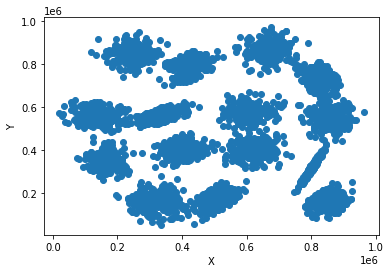

In [ ]:
plt.scatter(df.X,df['Y'])
plt.xlabel('X')
plt.ylabel('Y')

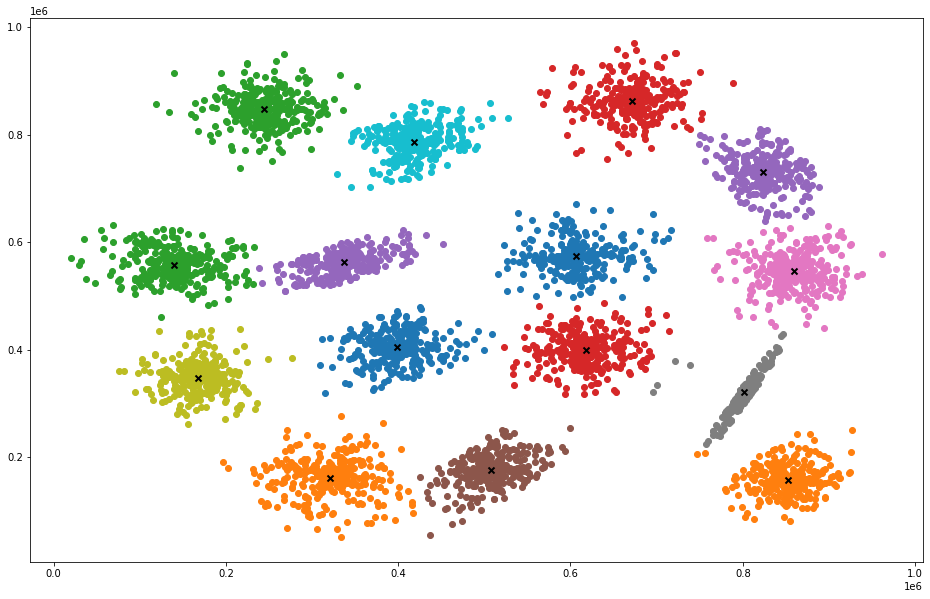

In [ ]:
X1=df['X'],df['Y']
#from sklearn.datasets import load_iris
#iris=load_iris()
#df=pd.DataFrame(iris.data,columns=iris.feature_names)

#using scipy distance function 
X=np.array(X1)
k=Kmeans(K=15,iter=150,p=2.1)
np.random.seed(42)
# np.shape(X.T)
# y_pred=k.predict(X.T,choice=0)
# k.plot()

y_pred=k.predict(np.array(df),choice=1)
k.plot()
# y_pred=k.predict(X.T,choice=2)
# k.plot()

<h1>Observation :</h1> 
For dataset1 we see at value of random_state = 1000 we get the correct expected clustering. This clearly suggests randomisation has to be run multiple times and the best one (need to make a metric for this) has to be picked.

<h1> Sci-Kit based observation for p = 2 

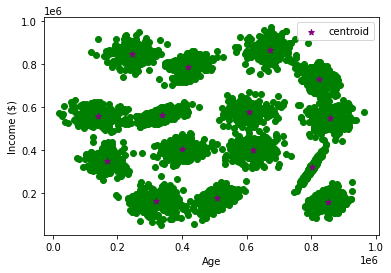

In [ ]:
#SCIKIT CLUSTERING : works as expected 

from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

km = KMeans(n_clusters=15)
y_predicted = km.fit_predict(df[['X','Y']])
y_predicted
df['cluster']=y_predicted
for i in range(0,16):
  df2 = df[df.cluster==i]
  plt.scatter(df2.X,df2['Y'],color='green')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('Age')
plt.ylabel('Income ($)')
plt.legend()

The dataset works without any user based trial and error

<h1> Some more implementation available on internet 

Do note all of them depend on the random component hence will fail if the selection of initial centroids are not as accurate as SciKit 

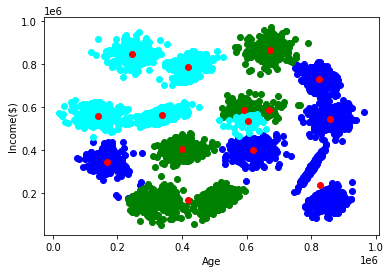

In [ ]:
# Step 1 and 2 - Choose the number of clusters (k) and select random centroid for each cluster

#number of clusters
K=15

# Select random observation as centroids
X=df[['X','Y']]

Centroids = (X.sample(n=K))
# Step 3 - Assign all the points to the closest cluster centroid
# Step 4 - Recompute centroids of newly formed clusters
# Step 5 - Repeat step 3 and 4

diff = 1
j=0

while(diff!=0):
    XD=X
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["X"]-row_d["X"])**2
            d2=(row_c["Y"]-row_d["Y"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        X[i]=ED
        i=i+1

    C=[]
    for index,row in X.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    X["Cluster"]=C
    Centroids_new = X.groupby(["Cluster"]).mean()[["X","Y"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['X'] - Centroids['X']).sum() + (Centroids_new['Y'] - Centroids['Y']).sum()
        # print(diff.sum())
    Centroids = X.groupby(["Cluster"]).mean()[["X","Y"]]

color=['blue','green','cyan','blue','green','cyan','blue','green','cyan','blue','green','cyan','blue','green','cyan']
for k in range(K):
    data=X[X["Cluster"]==k+1]
    plt.scatter(data["X"],data["Y"],c=color[k])
plt.scatter(Centroids["X"],Centroids["Y"],c='red')
plt.xlabel('Age')
plt.ylabel('Income($)')
plt.show()

This clearly proves that centroids must be picked correctly during random selection or else we might end up with different clusters (deviation from scikit) 
